## Tutorial: CTCF motif annotation with bioframe and rnalib

In this example we demonstrate how one could use _rnalib_ and _bioframe_ together for maximum benefit.
Briefly, we use _rnalib_ to instantiate a human Transcriptome (canonical protein-coding transcripts on chromosome 2 only), download an CTCF motif dataset with _bioframe_ and annotate all transcripts with those motifs. We then report all genes/transcripts with at least one overlapping CTCF motif. We demonstrate two annotation scenarios and compare their runtimes.

Required test resources
* gencode_39 GFF
* JASPAR ctcf sites

First, we load the required libraries.

In [1]:
import os, pathlib, platform
import rnalib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ssl
import bioframe
from collections import Counter

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

'Running rnalib 0.0.2 on python 3.12.1'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [2]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata at rnalib_testdata/'

Now, we use bioframe to read a set of CTCF binding sites from JASPAR and filter for chromosome 2 and 
minimum P-value.
NOTE that this cell might fail with a TimeoutError if the JASPAR data is not accessible.

In [3]:
# see https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=Grch38&g=jaspar
jaspar_uri='http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2022/hg38/MA0139.1.tsv.gz'
ssl._create_default_https_context = ssl._create_unverified_context # to avoid invalid certificate problems
ctcf = bioframe.read_table(jaspar_uri, schema='jaspar').query("chrom=='chr2' & pval>500")

Now, we annotate transcripts with JASPAR motifs. We demonstrate two different approaches:

- approach1
    - we instantiate a filtered rnalib transcriptome
    - we then annotate with the JASPAR motifs loaded via bioframe
    - for annotation we use a (very flexible) custom callback method
    - finally, we build a pandas dataframe with results containing one row per tx
- approach2
    - we read the GFF with bioframe and correct the start coordinate as bioframe expects 0-based coordinates
    - we overlap tx and ctcf sites with the bioframe overlap method (NOTE that we cannot use the inner join as it would change the order of the ctcf sites)
    - we create a results dataframe while filtering for the respective transcripts. This is done base on GFF attributes parsed from the 'attributes' column.

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/1244 [00:00<?, ?it/s]

'Annotating transcriptome'

  0%|          | 0/1 [00:00<?, ?it/s]

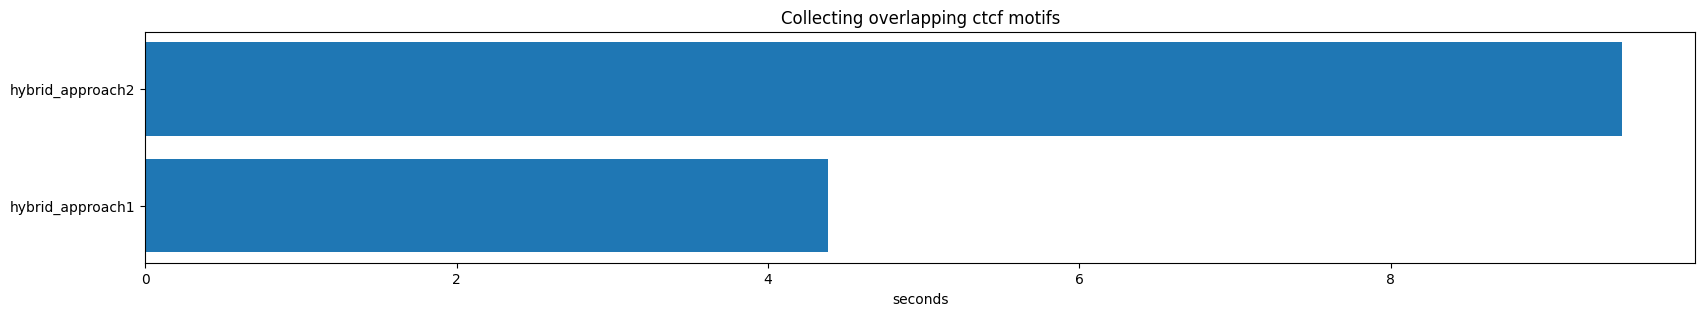

In [6]:
# gencode annotation GFF
times, results=Counter(),Counter()
with rna.Timer(times, 'hybrid_approach1') as timer:
    # Build subset of human transcriptome (canonical protein coding genes on chrom 2)
    t=rna.Transcriptome(
        annotation_gff=rna.get_resource("full_gencode_gff"),
        annotation_flavour='gencode',
        feature_filter = rna.TranscriptFilter().include_tags('Ensembl_canonical', include_missing=False).include_gene_types('protein_coding', include_missing=False).include_chromosomes('chr2')
    )
    # custom annotation method
    def anno_ctcf(item, label='ctcf_scores'):
        """ 
            Callback method for annotating transcripts.

            loc: genomic interval of the feature that is annotated
            anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
            dfrows: list of (loc, row) tuples containing all overlapping locations (loc) and the respective dataframe rows

            This method adds 'ctcf' annotations comprising of a list of (location, score) tuples that are overlapping the annotated transcript
        """
        loc, (anno, dfrows) = item
        if label not in anno:
            anno[label]=[]
        for sloc,dfrow in dfrows:
            anno[label].append((sloc,dfrow.score)) # add ctcf motif annotations
    # anotate all transcripts using the above defined anno_ctcf method
    display("Annotating transcriptome")     
    t.annotate(anno_its=rna.it(ctcf, style='bioframe'), 
               fun_anno=anno_ctcf, 
               feature_types=['transcript'])
    # build dataframe of transcripts with at least one overlapping CTCF peak
    results[timer.name]= pd.DataFrame([(tx.parent.gene_name, 
                                        tx.feature_id,
                                        str(tx.location),
                                        ','.join([str(l) for l,_ in tx.ctcf_scores]),
                                        ','.join([str(s) for _,s in tx.ctcf_scores])) for tx in t.transcript.values() if len(tx.ctcf_scores)>0], 
                                      columns=['gene','tid','location','ctcf_locations','ctcf_scores'])

    
with rna.Timer(times, 'hybrid_approach2') as timer:
    """ Here, we read the gencode annotation data via bioframe and correct the start coordinates as required.
        We then overlap with the ctcf sites and iterate over the resulting dataframe, parse the GFF attributes and
        filter for canonical, protein-coding genes. Finally, we build the result pandas dataframe.
    """
    tx = bioframe.read_table(rna.get_resource("full_gencode_gff"), schema='gff', comment='#').query("chrom=='chr2' & feature=='transcript'")
    tx['start']=tx['start']-1 # we need to correct start coordinates as bioframe coordinates are assumed to be 0-based and no correction is done (see above)
    over=bioframe.overlap(tx, ctcf, suffixes=('','_ctcf'), how='left', return_index=True) # NOTE: cannot use inner here as it will change order :/
    data={'gene':[], 'tid':[], 'location':[], 'ctcf_locations':[], 'ctcf_scores':[]}
    for loc, row in rna.it(over, style='bioframe'):
        info = rna.parse_gff_attributes(row.attributes) # parse gff attributes from attributes column.
        if not info.get('gene_type', 'NA') == 'protein_coding':
            continue
        if 'Ensembl_canonical' not in info.get('tag','NA'):
            continue
        if pd.isnull(row.start_ctcf): # filter tx w/o ctcf site
            continue
        data['gene'].append(info['gene_name'])
        data['tid'].append(info['transcript_id'])
        data['location'].append(str(loc))
        ctcf_loc = gi(row.chrom_ctcf, row.start_ctcf+1, row.end_ctcf, strand=row.strand_ctcf)
        data['ctcf_locations'].append(str(ctcf_loc)) # coorect coords
        data['ctcf_scores'].append(str(int(row.score_ctcf)))
    df = pd.DataFrame.from_dict(data) # create dataframe
    df = df.groupby(['gene','tid','location'], sort=False).agg(','.join).reset_index() # colapse rows while keeping sort order
    results[timer.name]=df


# assert that we get same results
assert len(results['hybrid_approach1'].compare(results['hybrid_approach2']).index)==0

rna.plot_times(f"Collecting overlapping ctcf motifs",
       times, reference_method='hybrid_approach1')

Approach1 is twice as fast, probably due to early filtering, and more flexible in our opinion. 
In the callback annotation method users have access to genomic locations and all data attributes of transcripts and the overlapping CTCF motifs as well as external data. 
They are also free to chose the created annotation data structures (here a list of location/score tuples). Together, this enables the implementation of complex annotation scenarios.